<a href="https://colab.research.google.com/github/HedersonSantos/SmartHome/blob/main/seriesTemporaisLSTM_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 31.0 MB/s 
     |████████████████████████████████| 9.8 MB 62.9 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('max_colwidth', None)


from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # para determinar (p,q)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.layers import LSTM
 

from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


In [4]:
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
!wget https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/sample_submission.csv

--2022-06-01 15:59:04--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 360467 (352K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 352.02K  --.-KB/s    in 0.005s  

2022-06-01 15:59:04 (66.9 MB/s) - ‘train.csv’ saved [360467/360467]

--2022-06-01 15:59:05--  https://raw.githubusercontent.com/HedersonSantos/SmartHome/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170613 (167K) [text/plain]
Saving to: ‘tes

In [5]:
def plotaSeries(treino, teste, predito):
  if type(treino) == pd.core.series.Series:
    treino.plot(legend=True,label='Treino')
  if type(teste) == pd.core.series.Series:
    teste.plot(legend=True,label='Teste',figsize=(16,8))
  if  type(predito)==pd.core.series.Series:
    predito.plot(legend=True) 
  else:
    for p in predito.columns:
      predito[p].plot(legend=True)

In [6]:
df_treino = pd.read_csv('train.csv')
df_treino['data_hora'] = df_treino.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_treino = df_treino.sort_values(by='data_hora')
df_treino = df_treino.set_index('data_hora')
#idx = pd.date_range(start=df_treino.index.min(), end=df_treino.index.max(),  freq='0h15min')
#df_treino= df_treino.reindex(idx)
dfx = df_treino[['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room']].resample('H').mean().iloc[1: , ]
df_treino = pd.DataFrame(dfx, columns = ['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor','Indoor_temperature_room'])
df_treino.fillna(method='ffill', inplace=True)

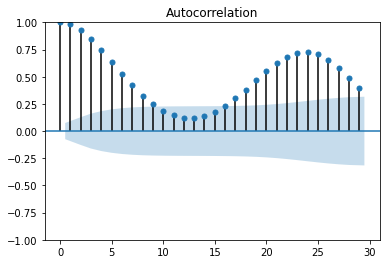

In [7]:
plot_acf(df_treino[['Indoor_temperature_room']])
plt.show();

In [8]:
min(df_treino.index), max(df_treino.index)

(Timestamp('2012-03-13 12:00:00', freq='H'),
 Timestamp('2012-04-11 06:00:00', freq='H'))

In [9]:
dfx = pd.DataFrame(df_treino).reset_index()
dfx['data'] =  dfx['data_hora'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [10]:
dfx.groupby('data')['data_hora'].count().reset_index().sort_values('data')

,data,data_hora
0,2012-03-13,12
1,2012-03-14,24
2,2012-03-15,24
3,2012-03-16,24
4,2012-03-17,24
5,2012-03-18,24
6,2012-03-19,24
7,2012-03-20,24
8,2012-03-21,24
9,2012-03-22,24


In [11]:
dfx.columns

Index(['data_hora', 'CO2_room', 'Relative_humidity_room', 'Lighting_room',
       'Outdoor_relative_humidity_Sensor', 'Indoor_temperature_room', 'data'],
      dtype='object')

In [12]:
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="13/03/2012"]
df_treino = df_treino[df_treino.index.strftime('%Y-%m-%d') !="11/04/2012"]

In [13]:
df_treino.head(5)

,CO2_room,Relative_humidity_room,Lighting_room,Outdoor_relative_humidity_Sensor,Indoor_temperature_room
data_hora,,,,,
2012-03-13 12:00:00,218.10525,42.159825,113.395750,46.934575,18.587525
2012-03-13 13:00:00,215.42125,42.037350,105.298675,45.278000,19.628500
2012-03-13 14:00:00,215.87200,42.110700,69.936675,44.540000,20.462000
2012-03-13 15:00:00,217.92250,40.829675,35.380675,45.130650,21.958325
2012-03-13 16:00:00,214.99200,39.751675,23.141000,44.878000,23.076000


In [14]:
#dividindo a amostra em treino e teste
dfTreino = df_treino[df_treino.index < datetime(2012,4,8,0,0)]
dfTeste = df_treino[df_treino.index >= datetime(2012,4,8,0,0)]
print(dfTreino.shape, dfTeste.shape)
print(min(dfTreino.index), max(dfTreino.index))
print(min(dfTeste.index), max(dfTeste.index))

(612, 5) (79, 5)
2012-03-13 12:00:00 2012-04-07 23:00:00
2012-04-08 00:00:00 2012-04-11 06:00:00


(array([[586.,  11.,   5.,   4.,   1.,   1.,   2.,   1.,   0.,   1.],
        [ 24.,  45.,  47.,  48.,  88.,  87., 100.,  67.,  63.,  43.],
        [402.,  35.,  15.,  12.,  35.,  12.,   6.,  31.,  20.,  44.],
        [ 15.,  26.,  44.,  67.,  83.,  80., 133., 100.,  30.,  34.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 4 Lists of Patches objects>)

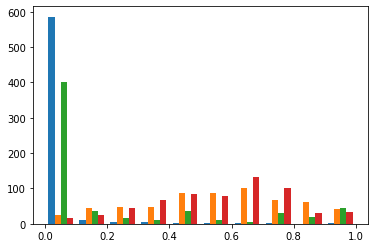

In [27]:
#padronizando os valores de 'confirmed' para o dataset de treino e teste - colocando todos os exemplos na mesma escala
scaler = MinMaxScaler()
#scaler.fit(dfTreino)
preditoras = ['CO2_room','Relative_humidity_room','Lighting_room','Outdoor_relative_humidity_Sensor']
alvo = ['Indoor_temperature_room']


scaled_train = scaler.fit_transform(dfTreino[preditoras])
scaled_tr_alvo = scaler.fit_transform(dfTreino[alvo])
scaled_test = scaler.fit_transform(dfTeste[preditoras])
scaled_ts_alvo = scaler.fit_transform(dfTeste[alvo])
scaled_all = scaler.fit_transform(df_treino[preditoras])
scaled_alvo = scaler.fit_transform(df_treino[alvo])
plt.hist(scaled_train)


In [31]:
dfTreino[preditoras].shape, dfTreino[alvo].shape

((612, 4), (612, 1))

In [16]:
#definindo o modelo e imprimindo a arquitetura
def modelo(n_input, n_features):
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
  #model.add(BatchNormalization())
  #model.add(Dropout(0.5))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse' )
  model.summary()
  return model

In [33]:
# gerando as entradas para a rede neural - (o gerador)

n_input = 24
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_tr_alvo, length=n_input, batch_size=1)
len(generator)
model = modelo(n_input, n_features)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 200)               161600    
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 161,801
Trainable params: 161,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator,epochs=10)

Epoch 1/10


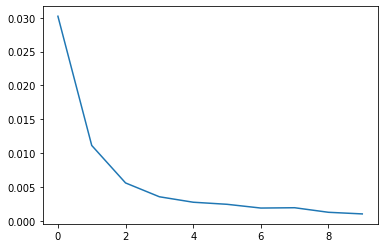

In [20]:
#verificando a descida do grandiente com a função loss = mse
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [21]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(scaled_test.shape[0]):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


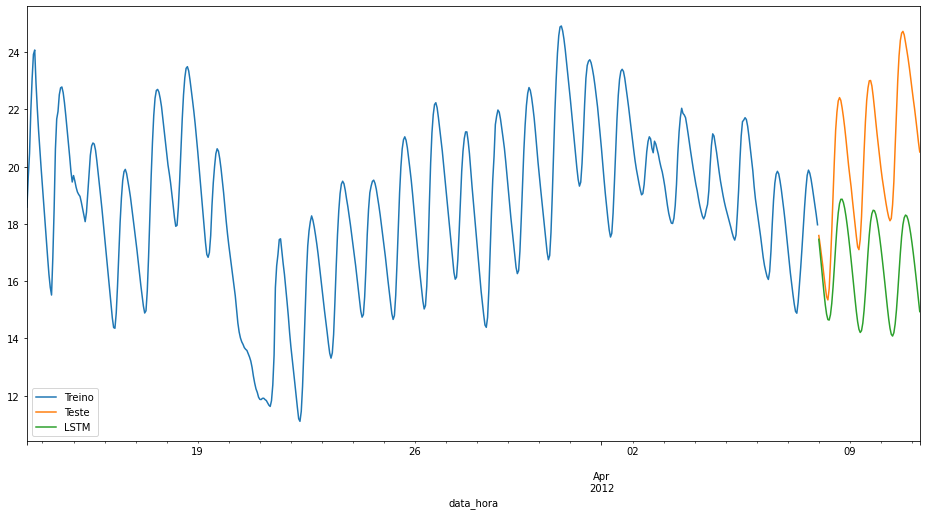

In [22]:
dfTeste['LSTM'] = true_predictions
plotaSeries(dfTreino['Indoor_temperature_room'], dfTeste['Indoor_temperature_room'], dfTeste['LSTM'])

In [23]:
n_input = 48
n_features = 1
generatorB = TimeseriesGenerator(scaled_all, scaled_all, length=n_input, batch_size=2)
len(generatorB)
modelB = modelo(n_input, n_features)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
322/322 [==============================] - 26s 79ms/step - loss: 0.0288
Epoch 2/10
322/322 [==============================] - 24s 75ms/step - loss: 0.0120
Epoch 3/10
322/322 [==============================] - 24s 75ms/step - loss: 0.0045
Epoch 4/10
322/322 [==============================] - 32s 99ms/step - loss: 0.0030
Epoch 5/10
322/322 [==============================] - 25s 76ms/step - loss: 0.0020
Epoch 6/10
322/322 [==============================] - 25s 77ms/step - loss: 0.0013
Epoch 7/10
322/322 [==============================] - 25s 78ms/step - loss: 0.0012
Epoch 8/10
322/322 [==============================] - 24s 75ms/step - loss: 9.4129e-04
Epoch 9/10
322/322 [==============================] - 24s 74ms/step - loss: 7.7363e-04
Epoch 10/10
322/322 [==============================] - 24s 75ms/step - loss: 6.9977e-04


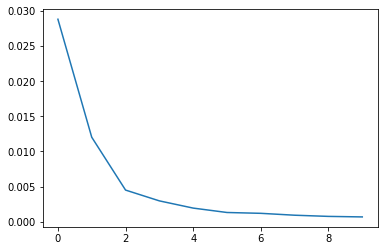

In [24]:
modelB.fit(generatorB,epochs=10)
loss_per_epoch = modelB.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [25]:
df_teste = pd.read_csv('test.csv')
df_teste['data_hora'] = df_teste.loc[:,['Date', 'Time']].apply(lambda x: datetime.strptime(x['Date'] + ' ' + x['Time'], '%d/%m/%Y %H:%M'), axis=1)
df_teste = df_teste.sort_values(by='data_hora')
df_teste = df_teste.set_index('data_hora')
#dfx = df_treino['Indoor_temperature_room'].resample('H').mean().iloc[1: , ]
#df_teste = pd.DataFrame(dfx, columns = ['Indoor_temperature_room'])
df_teste.fillna(method='ffill', inplace=True)


In [26]:
test_predictions = []
first_eval_batch = scaled_all[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(df_teste.shape[0]):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
true_predictions = scaler.inverse_transform(test_predictions)

In [27]:
true_predictions.shape, df_teste.shape


((1373, 1), (1373, 18))

In [28]:
df_teste['Indoor_temperature_room'] = true_predictions
df_teste['Id'] = df_teste['Id'].astype('int')
df_teste[['Id', 'Indoor_temperature_room']].to_csv('hederson_submition.csv', index=False)

In [29]:
!cat hederson_submition.csv
#!head sample_submission.csv

Id,Indoor_temperature_room
2764,20.10092947560549
2765,19.76764101074934
2766,19.47020927888155
2767,19.215976545450093
2768,19.023837741160396
2769,18.912549480885268
2770,18.893647963711622
2771,18.967943325230483
2772,19.12312051648796
2773,19.33421188308001
2774,19.56692662483752
2775,19.774963516792656
2776,19.925169571161273
2777,20.003255445140603
2778,20.005170460775496
2779,19.933494866991044
2780,19.795127989247444
2781,19.59922007851899
2782,19.3558122056067
2783,19.075009659376743
2784,18.766627924093605
2785,18.44010870195031
2786,18.104482040876153
2787,17.76852893797085
2788,17.434351299905032
2789,17.112206315968187
2790,16.82229509584457
2791,16.58747350756526
2792,16.429986112579705
2793,16.36842527570948
2794,16.413956707204136
2795,16.56711885084063
2796,16.814543234404177
2797,17.12974813910872
2798,17.475161056994647
2799,17.808121021748335
2800,18.085597813181582
2801,18.274009499767423
2802,18.368034626838565
2803,18.37238334248066
2804,18.29707037162185
2805,18

In [32]:
!ls -lh
!pwd

total 576K
-rw-r--r-- 1 root root  32K May 31 19:21 hederson_submition.csv
drwxr-xr-x 1 root root 4.0K May 17 13:39 sample_data
-rw-r--r-- 1 root root  13K May 31 19:12 sample_submission.csv
-rw-r--r-- 1 root root 167K May 31 19:12 test.csv
-rw-r--r-- 1 root root 353K May 31 19:12 train.csv
/content
